# Case Técnico

## 1.0 Contexto
- Trata-se de uma empresa de venda de commodites que busca prever qual será a porcentagem da meta atigida em janeiro de 2024.

## 2,0 Problema de Negócio
- Prever a porcentagem da meta de vendas em janeiro de 2024, para Colômbia/Equador, Peru e Brasil.

## 3.0 Reusmo
- Meu objetivo como Cientista de Dados é realizar uma Análise Exploratória dos Dados (EDA) e identificar oportunidades ocultas nos dados.
- Além disso, será desenvolvido um Modelo de Machine Learning capaz de prever a porcentagem da meta para janeiro de 2024.

## 4.0 Descrição dos Dados

### Temos 23 meses (fevereiro de 2022 a dezembro de 2023) com a porcentagem da meta para cada país
- Month/Year - Mês e ano.
- Value - Valor da meta atingida.
- Country - Paises  

## 5.0 Solução

Para a solução foi aplicada o método CRISP-DS, onde começamos com o acordo do negócio, descobrimos para coleta dos dados, limpeza dos dados, EDA (Análise Exploratória dos dados), modelagem, avaliação do modelo.

Foram desenvolvidos alguns modelos para fazer a previsão de Janeiro de 2024:
- Baseline
- ARIMA
- SARIMA
- LSTM
- Prophet

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings

# Ignorar todos os tipos de warnings
warnings.filterwarnings("ignore")

2024-09-11 15:23:19.864578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 15:23:22.806840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Load

In [2]:
# Carregando os dados (se estiverem em um arquivo CSV, por exemplo)
df_raw = pd.read_excel('/home/aroldo/market4u/WGG/Time-series-forecasting/data/Forecast_Value.xlsx', usecols="A:C")

# Verificando as primeiras linhas
df_raw.head()



,Month/Year,Value,Country
0,2022-02-01,0.58,Colombia/Ecuador
1,2022-03-04,0.61,Colombia/Ecuador
2,2022-04-04,0.65,Colombia/Ecuador
3,2022-05-05,0.39,Colombia/Ecuador
4,2022-06-05,0.53,Colombia/Ecuador


# Description Data

In [3]:
df1 = df_raw.copy()

## Data Dimension

In [4]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 69
Number of Cols: 3


## Data Types

In [5]:
df1.dtypes

Month/Year    datetime64[ns]
Value                float64
Country               object
dtype: object

## Check Na

In [6]:
df1.isna().sum()

Month/Year    0
Value         0
Country       0
dtype: int64

# EDA - Exploratory Data Analysis

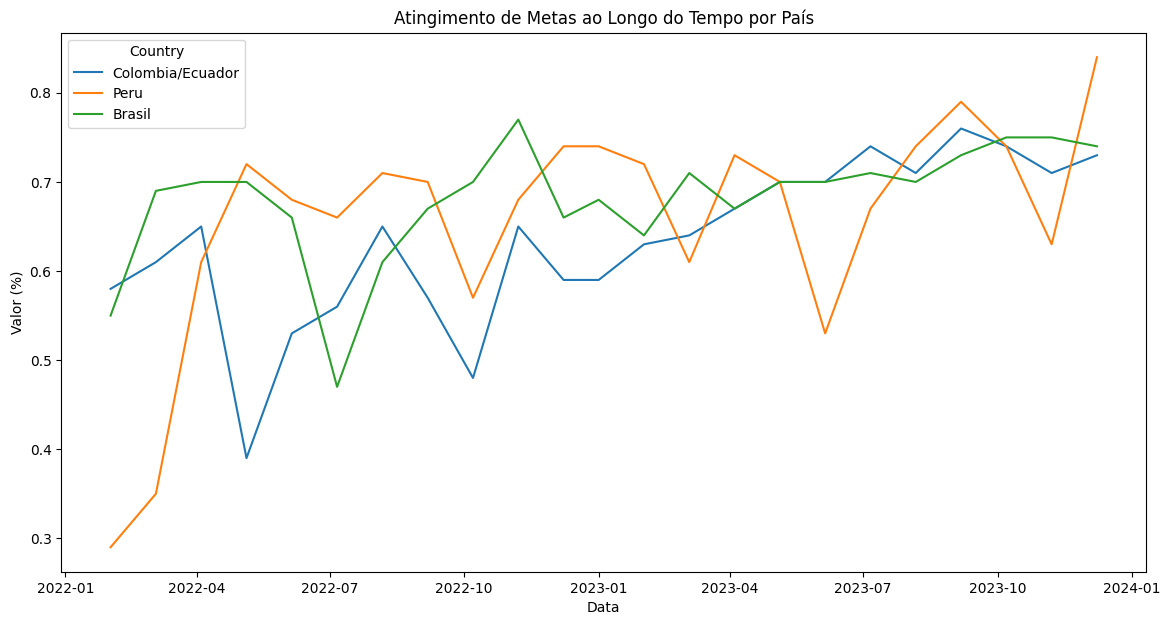

In [7]:
# Plotando os dados de cada país ao longo do tempo
plt.figure(figsize=(14, 7))
sns.lineplot(data=df1, x='Month/Year', y='Value', hue='Country')
plt.title('Atingimento de Metas ao Longo do Tempo por País')
plt.ylabel('Valor (%)')
plt.xlabel('Data')
plt.show()

_ Verificar se com a escala logarítmica a resultante vai para o formato de uma curva normal

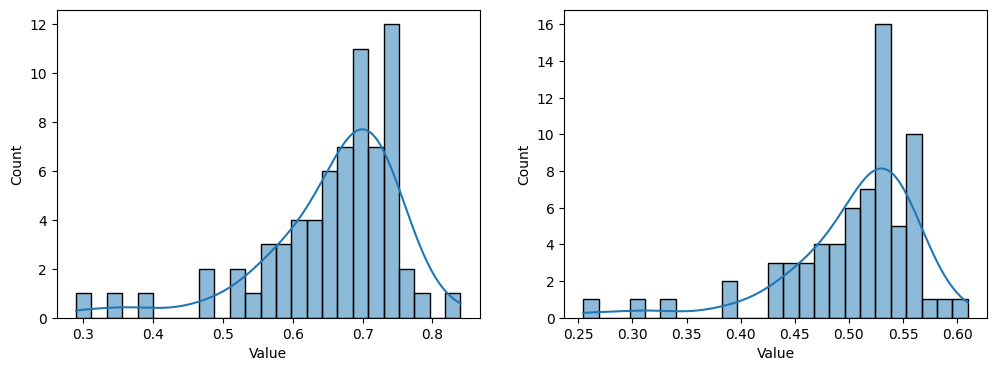

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df1['Value'], kde=True, bins=25)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df1['Value']), kde=True, bins=25)

plt.show()

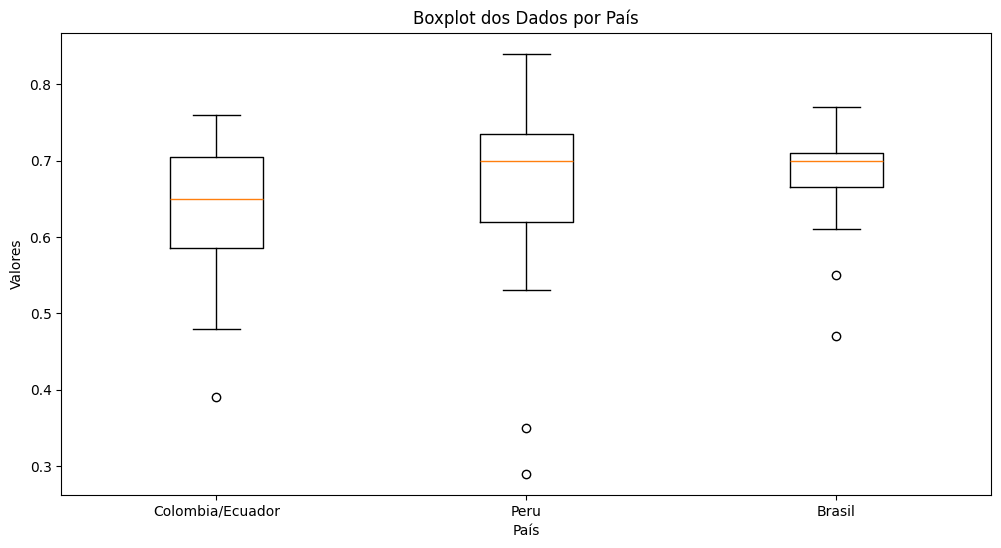

In [9]:
# Agrupar os dados por país
dados_por_pais = [df1[df1['Country'] == country]['Value'] for country in df1['Country'].unique()]

# Criar o boxplot para cada país
plt.figure(figsize=(12, 6))
plt.boxplot(dados_por_pais, labels=df1['Country'].unique())

# Adicionar título e rótulos
plt.title('Boxplot dos Dados por País')
plt.ylabel('Valores')
plt.xlabel('País')

# Mostrar o gráfico
plt.show()

## Previsão do Faturamento de Janeiro de 2024

- Vamos tentar prever com os dados que temos o valor da meta que será atingido em Janiro de 2024
- Portanto vamos aplicar uma media como baseline, para termos um ponto de partida e depois modelos de series temporais para prever a meta

# MACHINE LEARNING MODELLING

## Baseline

In [10]:
# Lista para armazenar erros e previsões do baseline
errors = []

# Lista de países para previsão
countries = ['Colombia/Ecuador', 'Peru', 'Brasil']

# Loop para calcular previsões e erros do baseline para cada país
for country in countries:
    df_country = df1[df1['Country'] == country].copy()

    # Dividir em dados de treino e teste (considerando que a última observação é o teste)
    train = df_country.iloc[:-1]
    test = df_country.iloc[-1:]

    # Criar o baseline: previsão será igual ao último valor observado
    baseline_forecast = train['Value'].mean()

    # Calcular os erros
    mae = mean_absolute_error(test['Value'], [baseline_forecast])
    mse = mean_squared_error(test['Value'], [baseline_forecast])
    rmse = np.sqrt(mse)

    # Adicionar erros e previsões à lista
    errors.append({
        'Model': 'Baseline',
        'Country': country,
        'Forecast': f"{baseline_forecast*100:.2f}%",
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

# Converter a lista de erros para DataFrame para melhor visualização
errors_df = pd.DataFrame(errors)

# Exibir os resultados
print('Baseline Forecast:')
print(errors_df[['Country', 'Forecast']])

Baseline Forecast:
            Country Forecast
0  Colombia/Ecuador   62.95%
1              Peru   65.05%
2            Brasil   67.82%


## ARIMA

In [11]:
df2 = df1.copy()

In [12]:
def forecast(df2, country, model_name="ARIMA"):
    df_country = df2[df2['Country'] == country].copy()
    
    # Dividir em dados de treino e teste (considerando que a última observação é o teste)
    train = df_country.iloc[:-1]
    test = df_country.iloc[-1:]

    # Ajustar o modelo ARIMA
    model = ARIMA(train['Value'], order=(1, 1, 0)).fit()
    
    # Fazer a previsão
    forecast_value = model.forecast(steps=1)
    
    # Calcular o erro
    mae = mean_absolute_error(test['Value'], forecast_value)
    mse = mean_squared_error(test['Value'], forecast_value)
    rmse = np.sqrt(mse)

    # Adicionar erros e previsões à lista
    errors.append({
        'Model': model_name,
        'Country': country,
        'Forecast': f"{forecast_value.values[0] * 100:.2f}%",  
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

def predict_arima(df2, country, steps=1, model_name="ARIMA"):
    df_country = df2[df2['Country'] == country].copy()
    
    # Dividir em dados de treino e teste (considerando que a última observação é o teste)
    train = df_country.iloc[:-1]
    
    # Ajustar o modelo SARIMA (utilizando ARIMA aqui como exemplo)
    model = ARIMA(train['Value'], order=(1, 1, 0)).fit()
    
    # Fazer a previsão
    forecast_value = model.forecast(steps=steps)
    
    return forecast_value


# Lista de países para previsão
countries = ['Colombia/Ecuador', 'Peru', 'Brasil']

# Previsão para cada país e cálculo do erro
for country in countries:
    forecast(df2, country)

# Converter a lista de erros para DataFrame para melhor visualização
errors_df = pd.DataFrame(errors)

# Previsão para janeiro de 2024 para cada país
forecast_colombia_ecuador = predict_arima(df2, 'Colombia/Ecuador', steps=1, model_name="ARIMA")
forecast_peru = predict_arima(df2, 'Peru', steps=1, model_name="ARIMA")
forecast_brasil = predict_arima(df2, 'Brasil', steps=1, model_name="ARIMA")

# Exibindo os resultados
print('Previsão para Jan-2024:')
print(f'Colombia/Ecuador: {forecast_colombia_ecuador.values[0]*100:.2f}%')
print(f'Peru: {forecast_peru.values[0]*100:.2f}%')
print(f'Brasil: {forecast_brasil.values[0]*100:.2f}%')



Previsão para Jan-2024:
Colombia/Ecuador: 72.22%
Peru: 62.19%
Brasil: 75.00%


## Prophet

# Data Preparation Prophet

In [13]:
df3 = df1.copy()

In [14]:
# Exemplo de DataFrame
df4 = pd.DataFrame(df3)

# Converter a coluna 'Month/Year' para datetime e depois para o formato desejado 'MMM-YY'
df3['Month/Year'] = pd.to_datetime(df3['Month/Year']).dt.strftime('%b-%y')

# Multiplicar os valores por 100
df3['Value'] = df3['Value'] * 100

# Converter o DataFrame em um dicionário de listas
dict_of_lists = df3.to_dict(orient='list')


In [15]:
# Criar DataFrame
df3 = pd.DataFrame(dict_of_lists)
df3['Month/Year'] = pd.to_datetime(df3['Month/Year'], format='%b-%y')
df3.columns = ['ds', 'y', 'country']

# Garantir que temos dados para cada país
countries = df3['country'].unique()

In [16]:
for country in countries:
    df_country = df3[df3['country'] == country].copy()
    
    # Criar o modelo Prophet
    model_prophet = Prophet(
    #yearly_seasonality="auto",    # Ajuste da sazonalidade anual com 10 Fourier terms
    changepoint_prior_scale=0.7,  # Aumenta a flexibilidade nas mudanças de tendência
    interval_width=0.95  # Define um intervalo de confiança de 95%
    )
    
    # Ajustar o modelo aos dados
    model_prophet.fit(df_country[['ds', 'y']])
    
    # Criar um DataFrame para prever o próximo período
    future = model_prophet.make_future_dataframe(periods=12, freq='M')  # Previsão para 12 meses à frente
    
    # Fazer previsões
    forecast_prophet = model_prophet.predict(future)
    
    # Filtrar previsões para janeiro de 2024
    forecast_jan_2024 = forecast_prophet[forecast_prophet['ds'] == '2024-01-31']

    # Renomear colunas para a tabela e formatar as datas
    forecast_jan_2024_renamed = forecast_jan_2024.rename(columns={
        'ds': '     data',
        'yhat': 'previsão',
        'yhat_lower': 'faixa_inferior',
        'yhat_upper': 'faixa_superior'
    })
    
    # Formatando os valores para melhorar a exibição
    forecast_jan_2024_renamed['     data'] = forecast_jan_2024_renamed['     data'].dt.strftime('%m-%Y')
    forecast_jan_2024_renamed[['previsão', 'faixa_inferior', 'faixa_superior']] = forecast_jan_2024_renamed[['previsão', 'faixa_inferior', 'faixa_superior']].applymap(lambda x: f'{x:.2f}%')

    # Exibir tabela formatada usando pandas com to_markdown()
    print(f'\nPrevisão para {country}:')
    print(forecast_jan_2024_renamed[['     data', 'previsão', 'faixa_inferior', 'faixa_superior']].to_markdown(index=False))

    # Calcular os erros para o conjunto de dados de treinamento
    y_true = df_country['y'].values
    y_pred = forecast_prophet.loc[forecast_prophet['ds'].isin(df_country['ds']), 'yhat'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

# Adicionar os resultados de erros e previsões à lista
    errors.append({
        'Model': 'Prophet',
        'Country': country,
        'Forecast': f"{forecast_jan_2024['yhat'].values[0]:.2f}%",  
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    })

# Criar DataFrame para erros e previsões
errors_df = pd.DataFrame(errors)


14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] done processing
14:41:31 - cmdstanpy - INFO - Chain [1] start processing



Previsão para Colombia/Ecuador:
|      data   | previsão   | faixa_inferior   | faixa_superior   |
|:------------|:-----------|:-----------------|:-----------------|
| 01-2024     | 75.83%     | 65.55%           | 85.29%           |


14:41:31 - cmdstanpy - INFO - Chain [1] done processing
14:41:31 - cmdstanpy - INFO - Chain [1] start processing
14:41:31 - cmdstanpy - INFO - Chain [1] done processing



Previsão para Peru:
|      data   | previsão   | faixa_inferior   | faixa_superior   |
|:------------|:-----------|:-----------------|:-----------------|
| 01-2024     | 79.69%     | 67.30%           | 92.09%           |

Previsão para Brasil:
|      data   | previsão   | faixa_inferior   | faixa_superior   |
|:------------|:-----------|:-----------------|:-----------------|
| 01-2024     | 76.39%     | 68.08%           | 85.63%           |


# SARIMA

In [17]:
df5 = df1.copy()

In [18]:
# Função para previsão SARIMA e cálculo de erros
def predict_sarima(df, country, steps=1, model_name="SARIMA"):
    try:
        df_country = df[df['Country'] == country].copy()
        
        # Ajuste do modelo SARIMA
        model_sarima = SARIMAX(df_country['Value'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
        model_sarima_fit = model_sarima.fit(disp=False)
        
        # Previsão para os próximos passos
        forecast_sarima = model_sarima_fit.forecast(steps=steps)
        
        # Calcular erros se houver dados de teste disponíveis
        if len(df_country) >= steps:
            actual_values = df_country['Value'].tail(steps).values
            predicted_values = forecast_sarima.values
            mse = mean_squared_error(actual_values, predicted_values)
            mae = mean_absolute_error(actual_values, predicted_values)
            rmse = np.sqrt(mse)
            
            # Adicionar erros à lista
            errors.append({
                'Model': model_name,
                'Country': country,
                'Forecast': f"{forecast_sarima.values[0] * 100:.2f}%",
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse
            })
        else:
            errors.append({
                'Model': model_name,
                'Country': country,
                'Forecast': 'N/A',
                'Error': 'Not enough data for error calculation'
            })
        
        return forecast_sarima

    except Exception as e:
        # Armazenar o erro na lista
        errors.append({
            'Model': model_name,
            'Country': country,
            'Forecast': 'N/A',
            'Error': str(e)
        })
        return None

# Previsão para janeiro de 2024 para cada país
forecast_colombia_ecuador = predict_sarima(df5, 'Colombia/Ecuador', steps=1, model_name="SARIMA")
forecast_peru = predict_sarima(df5, 'Peru', steps=1, model_name="SARIMA")
forecast_brasil = predict_sarima(df5, 'Brasil', steps=1, model_name="SARIMA")

# Exibindo os resultados
print('Previsão para Jan-2024:')
print(f'Colombia/Ecuador: {forecast_colombia_ecuador.values[0]*100:.2f}%')
print(f'Peru: {forecast_peru.values[0]*100:.2f}%')
print(f'Brasil: {forecast_brasil.values[0]*100:.2f}%')

# Criar DataFrame para erros
errors_df = pd.DataFrame(errors)


Previsão para Jan-2024:
Colombia/Ecuador: 69.47%
Peru: 83.95%
Brasil: 73.34%


# LSTM

In [19]:
df6 = df1.copy()

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Função para preparar os dados para a LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Função para treinar e prever com o modelo LSTM
def forecast_lstm(df6, country, time_step=12):
    error_list = []

    # Filtrar os dados do país
    df_country = df6[df6['Country'] == country].copy()

    if len(df_country) <= time_step:
        return error_list

    # Normalizar os dados
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_country['Scaled'] = scaler.fit_transform(df_country[['Value']])

    # Preparar os dados
    data = df_country['Scaled'].values.reshape(-1, 1)
    X, y = create_dataset(data, time_step)

    if X.shape[0] == 0:
        return error_list

    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Construir o modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compilar o modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X, y, epochs=100, batch_size=32, verbose=0)

    # Prever janeiro de 2024
    last_sequence = data[-time_step:]
    last_sequence = last_sequence.reshape(1, time_step, 1)
    jan_2024_prediction = model.predict(last_sequence)
    jan_2024_prediction = scaler.inverse_transform(jan_2024_prediction)

    forecast_value = jan_2024_prediction[0][0]

    # Previsões para os dados de teste
    if len(data) > time_step + 1:
        X_test, y_test = create_dataset(data, time_step)
        if len(X_test) > 0:
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test)
            predictions = scaler.inverse_transform(predictions)

            test_data = df_country.iloc[time_step:].copy()
            test_data['Predictions'] = predictions.flatten()

            # Calcular os erros
            mae = mean_absolute_error(test_data['Value'], test_data['Predictions'])
            mse = mean_squared_error(test_data['Value'], test_data['Predictions'])
            rmse = np.sqrt(mse)

            # Adicionar os erros e previsões à lista
            error_list.append({
                'Model': 'LSTM',
                'Country': country,
                'Forecast': f"{forecast_value * 100:.2f}%",
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse
            })

    return error_list

# Lista de países para previsão
countries = ['Colombia/Ecuador', 'Peru', 'Brasil']

# Previsão para cada país e cálculo do erro
for country in countries:
    country_error = forecast_lstm(df6, country)
    if country_error:
        errors.extend(country_error)

# Criar DataFrame para erros
errors_df = pd.DataFrame(errors)

# Filtrar apenas os resultados para o modelo LSTM
lstm_errors_df = errors_df[errors_df['Model'] == 'LSTM']

  

2024-09-01 14:41:35.282968: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-01 14:41:35.284967: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


## Tabela comparativa com todos os dados do baseline e dos outros modelos separados por país

In [21]:
errors_df

,Model,Country,Forecast,MAE,MSE,RMSE
0,Baseline,Colombia/Ecuador,62.95%,0.100455,1.009112e-02,0.100455
1,Baseline,Peru,65.05%,0.189545,3.592748e-02,0.189545
2,Baseline,Brasil,67.82%,0.061818,3.821488e-03,0.061818
3,ARIMA,Colombia/Ecuador,72.22%,0.007756,6.016241e-05,0.007756
4,ARIMA,Peru,62.19%,0.218090,4.756313e-02,0.218090
5,ARIMA,Brasil,75.00%,0.010000,1.000000e-04,0.010000
6,Prophet,Colombia/Ecuador,75.83%,3.363194,2.478807e+01,4.978762
7,Prophet,Peru,79.69%,5.017532,3.843222e+01,6.199373
8,Prophet,Brasil,76.39%,2.896693,1.638389e+01,4.047701
9,SARIMA,Colombia/Ecuador,69.47%,0.035262,1.243378e-03,0.035262


## Plotagem dos gráficos com as previsões

14:42:05 - cmdstanpy - INFO - Chain [1] start processing
14:42:05 - cmdstanpy - INFO - Chain [1] done processing


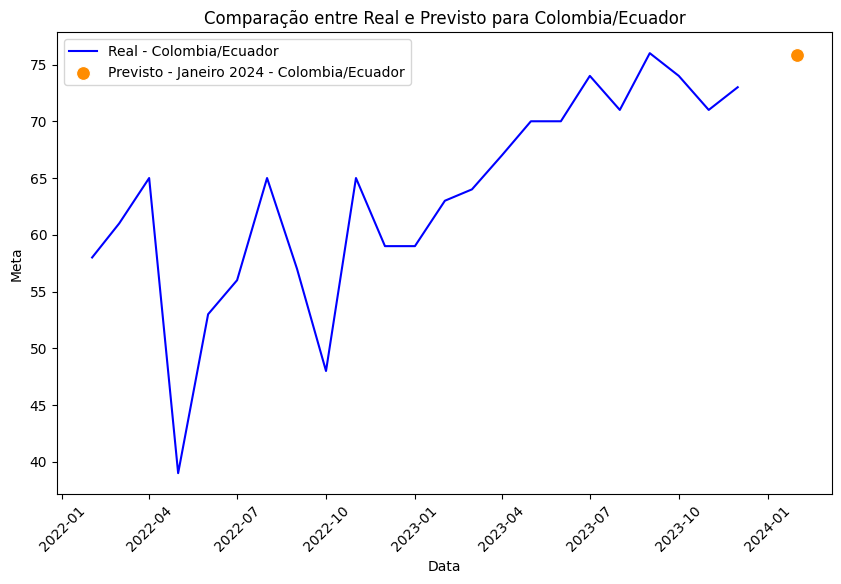

14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:42:06 - cmdstanpy - INFO - Chain [1] done processing


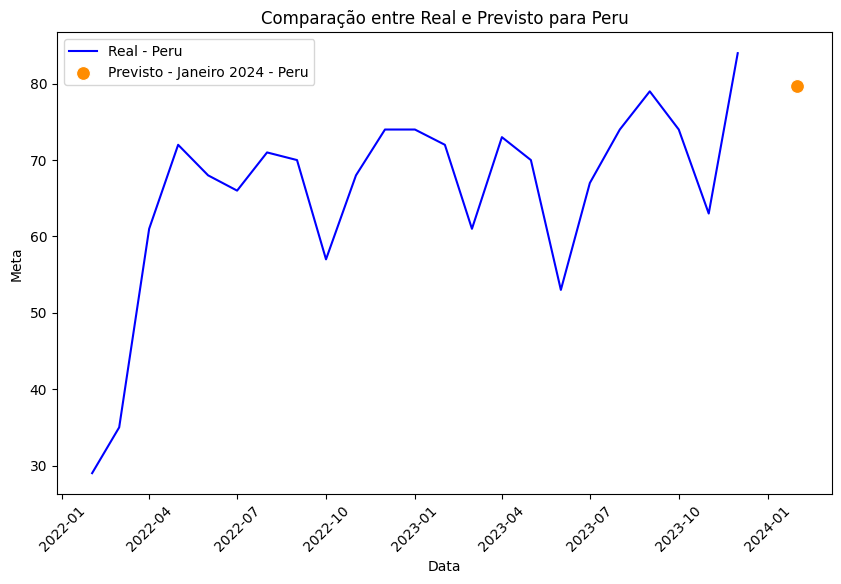

14:42:07 - cmdstanpy - INFO - Chain [1] start processing
14:42:07 - cmdstanpy - INFO - Chain [1] done processing


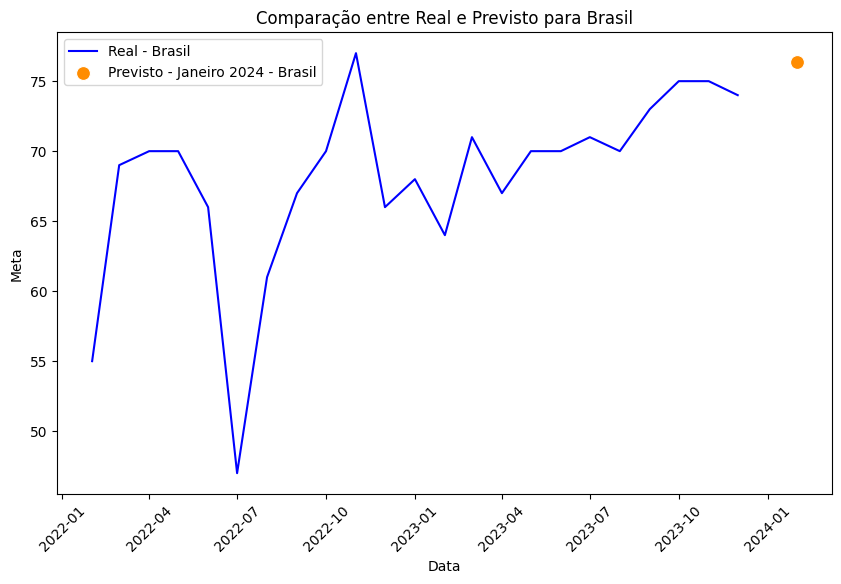

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop para iterar sobre os países
for country in countries:
    # Filtrar os dados para o país específico
    df_country = df3[df3['country'] == country].copy()
    
    # Ordenar os dados por data
    df_country = df_country.sort_values(by='ds')

    # Criar o modelo Prophet
    model_prophet = Prophet(changepoint_prior_scale=0.7, interval_width=0.95)
    model_prophet.fit(df_country[['ds', 'y']])
    
    # Fazer previsões
    future = model_prophet.make_future_dataframe(periods=8, freq='M')
    forecast_prophet = model_prophet.predict(future)
    
    # Filtrar a previsão para janeiro de 2024
    forecast_jan_2024 = forecast_prophet[forecast_prophet['ds'] == '2024-01-31']
    
    # Plotar os dados reais e a previsão de janeiro de 2024
    plt.figure(figsize=(10, 6))

    sns.lineplot(x='ds', y='y', data=df_country, color='blue', label=f'Real - {country}')
    sns.scatterplot(x='ds', y='yhat', data=forecast_jan_2024, color='darkorange', label=f'Previsto - Janeiro 2024 - {country}', s=100)

    # Adicionando rótulos aos eixos e título
    plt.xlabel('Data')
    plt.ylabel('Meta')
    plt.title(f'Comparação entre Real e Previsto para {country}')
    plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor leitura
    plt.legend()

    plt.show()


In [23]:
forecast_jan_2024

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
24,2024-01-31,76.38537,66.938929,85.171383,71.704161,80.343355,0.0,0.0,0.0,0.0,0.0,0.0,76.38537


# Considerações finais

### Com poucos dados no total 23 meses para cada país, a base de dados não é ideal, mas acredito que o modelo que melhor generalizou foi o Prophet, superando o baseline. Sendo assim, as previsões que considero para janeiro de 2024 são:
| Model   | Country            | Forecast | MAE       | MSE          | RMSE     |
|---------|--------------------|----------|-----------|--------------|----------|
| Prophet | Colombia/Ecuador   | 75.83%   | 3.363194  | 2.478807e+01 | 4.978762 |
| Prophet | Peru               | 79.69%   | 5.017532  | 3.843222e+01 | 6.199373 |
| Prophet | Brasil             | 76.39%   | 2.896693  | 1.638389e+01 | 4.047701 |

In [24]:
value_jan_dez_2023 = df1[(df1['Month/Year'].dt.month.isin([1,12])) & (df1['Month/Year'].dt.year == 2023)]
# Filtrar os dados para os meses de janeiro e dezembro de 2023
value_jan_dez_2023 = df1[(df1['Month/Year'].dt.year == 2023) & 
                         (df1['Month/Year'].dt.month.isin([1, 12]))]

# Ordenar os dados por data
value_jan_dez_2023_sorted = value_jan_dez_2023.sort_values(by='Month/Year')

# Exibir os dados ordenados
value_jan_dez_2023_sorted


,Month/Year,Value,Country
11,2023-01-01,0.59,Colombia/Ecuador
34,2023-01-01,0.74,Peru
57,2023-01-01,0.68,Brasil
22,2023-12-08,0.73,Colombia/Ecuador
45,2023-12-08,0.84,Peru
68,2023-12-08,0.74,Brasil


### Tabela comparativa da previsão com Janeiro de 2023 para verificar a evolução depois de 12 meses
| Country            | Relação a Janeiro de 2023 |
|--------------------|---------------------------|
| Colombia/Ecuador   |   acréscimo  de  28.52%   |
| Peru               |   acréscimo   de  7.69%   |
| Brasil             |   acréscimo  de  12.34%   |

- Colômbia/Equador: Houve um aumento significativo de 28.52% na meta atingida em relação a janeiro de 2023, indicando um desempenho substancialmente melhor ao longo do ano.
- Peru: Apresenta um crescimento mais moderado, com um acréscimo de 7.69% em relação ao mesmo período do ano anterior.
- Brasil: Registrou um crescimento de 12.34% em relação a janeiro de 2023, mostrando uma tendência de melhoria, embora menos acentuada do que a Colômbia/Equador.


### Tabela comparativa da previsão com Dezembro de 2023 para verificar a evolução sequencial
| Country            | Relação a dezembro 2023 |
|--------------------|-------------------------|
| Colombia/Ecuador   |  acréscimo   de  3.74%  |
| Peru               |  decréscimo  de -5.13%  |
| Brasil             |  acréscimo   de  3.23%  |

- Colômbia/Equador e Brasil: Ambos os países mostram um crescimento em relação a dezembro de 2023, com acréscimos de 3.74% e 3.23%, respectivamente. Isso indica uma tendência positiva para janeiro de 2024.
- Peru: Apresenta uma queda de -5.13% em relação a dezembro de 2023, sugerindo uma possível desaceleração nas vendas para janeiro de 2024.

## Proximos Passos

-Realizar novos ciclos com o objetivo de melhorar o modelo.
- Colocar o modelo em produção.
- Defina como será disponibilizado o acesso ao modelo pelo usuário.
- Melhorar a base de dados.